### Evaluation

In [1]:
from tsai.basics import *
from sklearn.metrics import mean_squared_error, mean_absolute_error
from swdf.utils import *

/usr/local/pip-global/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
learn = load_learner_all('tmp', verbose=True) # learn = load_learner('models/patchTST.pt')

Learner loaded:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth']'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


In [3]:
y_test_preds, y_test = learn.get_preds(ds_idx = 2, with_targs=True)
y_test_preds = to_np(y_test_preds)
y_test = to_np(y_test)
print(f"y_test_preds.shape: {y_test_preds.shape}")     

y_test_preds.shape: (1912, 4, 6)


In [4]:
horizon = y_test.shape[-1]
data_columns_fcst = ['F10', 'S10', 'M10', 'Y10']

The evaluation is done for each variable separately, for each solar activity 
level (low, moderate, elevated and high), as in the paper by Licata et al. (2020)
Therefore, the test set has to be split into 4 different sets, one for each solar activity level. The thresholds for each solar activity level are the same as in the paper by Licata et al. (2020)

The thresholds are:
- F10: 75, 150, 190
- S10: 65, 150, 215
- M10: 72, 144, 167
- Y10: 81, 148, 165

In [5]:
#|export

def get_idxs_per_solar_activity_level(data, thresholds):
    # function that splits the data of a variable into 4 different sets, 
    # one for each solar activity level. The data comes as a numpy array with 
    # shape (samples, steps), and the split is done along the samples axis. 
    # The decision is made based on the first column of each sample. The function 
    # returns a list of 4 numpy arrays, one for each solar activity level. 
    # But it does not return the values, it returns the indices of the
    # samples that belong to each solar activity level.
    idxs_per_solar_activity_level = []
    for i in range(len(thresholds) + 1):
        if i == 0:
            idxs = np.where(data[:, 0] <= thresholds[i])[0]
        elif i == len(thresholds):
            idxs = np.where(data[:, 0] > thresholds[i-1])[0]
        else:
            idxs = np.where((data[:, 0] > thresholds[i-1]) & (data[:, 0] <= thresholds[i]))[0]
        idxs_per_solar_activity_level.append(idxs)
    return idxs_per_solar_activity_level

In [6]:
# Call the function for each variable, using y_test
thresholds = {'F10': [75, 150, 190], 
              'S10': [65, 150, 215], 
              'M10': [72, 144, 167], 
              'Y10': [81, 148, 165]}

y_test_split_idxs = {}
for i, var in enumerate(data_columns_fcst):
    y_test_split_idxs[var] = get_idxs_per_solar_activity_level(y_test[:, i, :], 
                                                               thresholds[var])
# Check the shape of each variable
for var in data_columns_fcst:
    print(f"{var}: {[y_test_split_idxs[var][i].shape for i in range(4)]}")

F10: [(246,), (1436,), (207,), (23,)]
S10: [(139,), (1485,), (288,), (0,)]
M10: [(225,), (1418,), (239,), (30,)]
Y10: [(127,), (1684,), (97,), (4,)]


In [7]:
# Now split y_test and y_test_preds with the idxs we got, using numpy.take
y_test_split = {}
y_test_preds_split = {}
for var in data_columns_fcst:
    y_test_split[var] = [y_test[:, i, :].take(y_test_split_idxs[var][i], axis=0) for i in range(4)]
    y_test_preds_split[var] = [y_test_preds[:, i, :].take(y_test_split_idxs[var][i], axis=0) for i in range(4)]

# Check the shape of each variable in y_test_split
for var in data_columns_fcst:
    print(f"y_test-{var}: {[y_test_split[var][i].shape for i in range(4)]}")
    print(f"y_test_preds-{var}: {[y_test_preds_split[var][i].shape for i in range(4)]}")

y_test-F10: [(246, 6), (1436, 6), (207, 6), (23, 6)]
y_test_preds-F10: [(246, 6), (1436, 6), (207, 6), (23, 6)]
y_test-S10: [(139, 6), (1485, 6), (288, 6), (0, 6)]
y_test_preds-S10: [(139, 6), (1485, 6), (288, 6), (0, 6)]
y_test-M10: [(225, 6), (1418, 6), (239, 6), (30, 6)]
y_test_preds-M10: [(225, 6), (1418, 6), (239, 6), (30, 6)]
y_test-Y10: [(127, 6), (1684, 6), (97, 6), (4, 6)]
y_test_preds-Y10: [(127, 6), (1684, 6), (97, 6), (4, 6)]


In [8]:
#| export

def forecast_error(y_true, y_pred, h):
    # The forecast error is defined as the difference  between the forecasted value 
    # and the actual value. It is also dependant on the time, i.e., on the horizon 
    # of the forecast (h).
    # NOTE: This function computes the error for just one variable, not for all of them
    # Inputs:
    # y_true: actual values (samples x steps)
    # y_pred: predicted values (samples x steps)
    # h: horizon of the forecast (1..horizon)
    return (y_pred[:, h-1] - y_true[:, h-1])

def percent_forecast_error(y_true, y_pred, h):
    # forecast error normalized by the actual value
    # Inputs:
    # y_true: actual values (samples x steps)
    # y_pred: predicted values (samples x steps)
    # h: horizon of the forecast (1..horizon)
    return 100*(forecast_error(y_true, y_pred, h) / y_true[:, h-1])

In [9]:
#| hide

# Test with random data (torch)
foo = torch.rand(10, 3)
bar = torch.rand(10, 3)
print(forecast_error(foo, bar, 1))
print(percent_forecast_error(foo, bar, 1))

tensor([-0.5288,  0.6782,  0.1164,  0.5318, -0.8207,  0.4524, -0.1266, -0.4292,
         0.6830,  0.2112])
tensor([-67.5117, 252.1294,  21.2793, 219.5102, -87.6407,  97.2551, -49.4395,
        -97.5290, 385.4288,  45.3412])


In [18]:
# Create a table (dataframe) with the mean forecast error for each variable (F10, S10, M10, Y10), 
# each solar activity level and each horizon (1..horizon)
data = []
sals = ['low', 'moderate', 'elevated', 'high']
for var_idx, var in enumerate(data_columns_fcst):
    for sal_idx,sal in enumerate(sals):
        for h in range(1, horizon+1):
            fe_sfu = forecast_error(y_test_split[var][sal_idx], 
                                y_test_preds_split[var][sal_idx], h)
            fe_percent = percent_forecast_error(y_test_split[var][sal_idx],
                                            y_test_preds_split[var][sal_idx], h)
            n_samples = y_test_split[var][sal_idx].shape[0]
            data.append([var, sal, h, np.mean(fe_sfu), np.std(fe_sfu), 
                        np.mean(fe_percent), np.std(fe_percent), n_samples])
df_results = pd.DataFrame(data, columns=['variable', 'condition', 'horizon', 
                                         'mean_sfu', 'std_sfu', 'mean_percent', 
                                         'std_percent', 'n_samples'])
df_results.head(10)

/usr/local/pip-global/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/pip-global/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/pip-global/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/pip-global/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/pip-global/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


,variable,condition,horizon,mean_sfu,std_sfu,mean_percent,std_percent,n_samples
0,F10,low,1,0.410694,1.341377,0.576043,1.847166,246
1,F10,low,2,0.394799,1.893659,0.574612,2.578170,246
2,F10,low,3,0.482746,2.633576,0.729053,3.531826,246
3,F10,low,4,0.564156,3.362087,0.890133,4.442636,246
4,F10,low,5,0.544815,4.155794,0.940641,5.362697,246
5,F10,low,6,0.451669,4.922103,0.899071,6.191888,246
6,F10,moderate,1,0.045924,2.785973,0.084542,2.355547,1436
7,F10,moderate,2,0.060314,4.317620,0.160966,3.619334,1436
8,F10,moderate,3,0.103154,5.722363,0.290064,4.772163,1436
9,F10,moderate,4,0.150461,7.039228,0.443404,5.845906,1436


In [19]:
# Divide the table into one dataframe for each variable, and print it in a way
# that has the same format as the table in the paper, that is:
# Columns: | Condition | Statistics | 1 Day | 2 Days | 3 Days | ... | {{horizon}} Days,
# where condition is the variable and the solar activity level, and statistics 
# is the mean (column mean_fe) and the standard deviation (std_fe) of the forecast error.
for i, var in enumerate(data_columns_fcst):
    df_var = df_results[df_results['variable'] == var]

    df_var = df_var.melt(id_vars=['condition', 'horizon'], 
                         value_vars=['mean_sfu', 'std_sfu'], 
                         var_name='Statistic')
    # Sort the values of the column condition so that the order is 
    # low, moderate, elevated, high
    df_var['condition'] = pd.Categorical(df_var['condition'], 
                                      categories=['low', 'moderate', 'elevated', 'high'], 
                                      ordered=True)
    df_var = df_var.pivot_table(index=['condition', 'Statistic'], 
                          columns='horizon', 
                          values='value')
    # pretty print, and separate with a blank line
    print(f'Distribution Statistics {var} Error Distribution \n{df_var.to_string()}\n')

Distribution Statistics F10 Error Distribution 
horizon                     1         2         3          4          5          6
condition Statistic                                                               
low       mean_sfu   0.410694  0.394799  0.482746   0.564156   0.544815   0.451669
          std_sfu    1.341377  1.893659  2.633576   3.362087   4.155794   4.922103
moderate  mean_sfu   0.045924  0.060314  0.103154   0.150461   0.148232   0.098631
          std_sfu    2.785973  4.317620  5.722363   7.039228   8.249575   9.230431
elevated  mean_sfu  -1.907539 -2.658457 -3.065202  -3.165927  -2.915451  -2.545068
          std_sfu    3.683705  6.003737  8.594364  10.465365  12.049464  12.971416
high      mean_sfu  -1.832492 -2.446447 -3.579204  -4.137961  -3.331656  -1.671218
          std_sfu    3.648182  4.543215  4.947744   6.222694   7.916521   9.338687

Distribution Statistics S10 Error Distribution 
horizon                     1         2         3          4          5  

In [20]:
# Convert df_results into long format
df_results_lf = df_results.melt(id_vars=['variable', 'condition', 'horizon'],
                                value_vars=['mean_sfu', 'std_sfu', 'mean_percent', 'std_percent'],
                                var_name='statistic')

# Filter out the percent statistics
df_results_lf = df_results_lf[df_results_lf['statistic'].str.contains('percent') == False]

# Rename the Statistic 'mean_sfu' to just 'mean' and 'std_sfu' to 'std'
df_results_lf['statistic'] = df_results_lf['statistic'].str.replace('_sfu', '')

df_results_lf.head()

,variable,condition,horizon,statistic,value
0,F10,low,1,mean,0.410694
1,F10,low,2,mean,0.394799
2,F10,low,3,mean,0.482746
3,F10,low,4,mean,0.564156
4,F10,low,5,mean,0.544815


In [24]:
# Compare these results with the results in the paper. The results in the paper
# can be found in the data folder as a csv
df_results_paper = pd.read_csv('../data/paper_results.csv')

# Filter out the rows with Statistics = 'EBM'
df_results_paper = df_results_paper[df_results_paper['statistic'] != 'EBM']

# Rename the values of the column condition to the ones of the sals variable
df_results_paper['condition'] = df_results_paper['condition'].str.replace('Low solar', 'low')
df_results_paper['condition'] = df_results_paper['condition'].str.replace('Moderate solar', 'moderate')
df_results_paper['condition'] = df_results_paper['condition'].str.replace('Elevated solar', 'elevated')
df_results_paper['condition'] = df_results_paper['condition'].str.replace('High solar', 'high')

df_results_paper.head()

,variable,condition,statistic,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days
0,F10,low,mean,-0.2685,-0.7472,-0.6672,-0.3721,-0.0674,0.2428
1,F10,low,std,3.6985,4.7031,5.5001,6.1683,6.7677,7.2050
3,F10,moderate,mean,-0.8251,-0.8095,-0.9639,-1.1450,-1.1456,-1.1679
4,F10,moderate,std,12.0854,14.9853,17.8425,20.2973,21.9353,23.3389
6,F10,elevated,mean,5.7270,7.2425,9.0385,10.3829,11.0017,10.9559


In [25]:
# Convert df_results_paper into long format
df_results_paper_lf = df_results_paper.melt(id_vars=['variable', 'condition', 'statistic'],
                                            value_vars=[f'{i} Days' for i in range(1, horizon+1)],
                                            var_name='horizon', value_name='value')

# Convert the value sof the horizon column to int
df_results_paper_lf['horizon'] = df_results_paper_lf['horizon'].str.replace(' Days', '').astype(int)
df_results_paper_lf.head()

,variable,condition,statistic,horizon,value
0,F10,low,mean,1,-0.2685
1,F10,low,std,1,3.6985
2,F10,moderate,mean,1,-0.8251
3,F10,moderate,std,1,12.0854
4,F10,elevated,mean,1,5.7270


In [26]:
# Join the two dataframes (df_results_ours and df_results_paper) on the columns 
# variable, condition and Statistic
df_results_joined = df_results_lf.merge(df_results_paper_lf, how='left', 
                                            on=['variable', 'condition', 'statistic', 'horizon'],
                                            suffixes=('_ours', '_paper'))
len(df_results_lf), len(df_results_paper_lf), len(df_results_joined)

(192, 186, 192)

In [27]:
# Reshape the table so that it compares the results of our model with the results 
# of the paper. Create one table for each variable, and print it in a way that has
# the following format:
# Columns: | Condition | 1 Day | 2 Days | 3 Days | ... | {{horizon}} Days
# where condition is the variable and the solar activity level, and the values
# for each horizon are the concatenation of the mean and the standard deviation
# (with the symbol ±) of the forecast error of our model and the paper.

# Spread the values of the column statistic.
foo = df_results_joined.pivot_table(index=['variable', 'condition', 'horizon'],
                                                    columns='statistic',
                                                    values=['value_ours', 'value_paper'])


# Mutate the columns mean and std so that they are bolded in case they are the the 
# higher that the same statistic in the paper, or vice versa. The mutated column
# will not replace the original column, but will be added as a new column. Don't
# use the apply function
foo.loc[:, ('value_ours', 'mean_str')] = np.where(np.abs(foo['value_ours']['mean']) < np.abs(foo['value_paper']['mean']), 
                    '\\textbf{' + foo['value_ours']['mean'].astype(str) + '}',
                    foo['value_ours']['mean'].astype(str))
foo.loc[:, ('value_ours', 'std_str')] = np.where(np.abs(foo['value_ours']['std']) < np.abs(foo['value_paper']['std']),
                    '\\textbf{' + foo['value_ours']['std'].astype(str) + '}',
                    foo['value_ours']['std'].astype(str))
foo.loc[:, ('value_paper', 'mean_str')] = np.where(np.abs(foo['value_paper']['mean']) < np.abs(foo['value_ours']['mean']),
                    '\\textbf{' + foo['value_paper']['mean'].astype(str) + '}',
                    foo['value_paper']['mean'].astype(str))
foo.loc[:, ('value_paper', 'std_str')] = np.where(np.abs(foo['value_paper']['std']) < np.abs(foo['value_ours']['std']),
                    '\\textbf{' + foo['value_paper']['std'].astype(str) + '}',
                    foo['value_paper']['std'].astype(str))

# Drop the columns mean and std but not the mutated columns mean_str and std_str
foo = foo.drop(columns=[('value_ours', 'mean'), ('value_ours', 'std'),
                        ('value_paper', 'mean'), ('value_paper', 'std')])

# Unite the mean and the standard deviation into a single column for both our
# model and the paper, and drop the mean_str and std_str columns
foo.loc[:, ('value_ours', 'mean ± std')] = foo['value_ours']['mean_str'] + ' ± ' + foo['value_ours']['std_str']
foo.loc[:, ('value_paper', 'mean ± std')] = foo['value_paper']['mean_str'] + ' ± ' + foo['value_paper']['std_str']
foo = foo.drop(columns=[('value_ours', 'mean_str'), ('value_ours', 'std_str'),
                        ('value_paper', 'mean_str'), ('value_paper', 'std_str')])

# Drop the level 0 of the columns, and rename the columns
foo.columns = foo.columns.droplevel(0)
foo.columns = ['NN', 'benchmark']

# Reset the index
foo = foo.reset_index()

# Sort the values of the column condition so that the order is 
# low, moderate, elevated, high
foo['condition'] = pd.Categorical(foo['condition'], categories=['low', 'moderate', 'elevated', 'high'], ordered=True)
foo = foo.sort_values(by=['variable', 'condition'])


# Print as a Latex table, one table for each variable
for variable in data_columns_fcst:
    print(foo[foo['variable'] == variable].drop(columns='variable').to_latex(
        index=False, 
        escape=False,
        column_format='|l|' + '|c|' * horizon,
        caption=f'Comparison of the results of the paper with the results of our model for the variable {variable}',
        label=f'tab:comparison_{variable}'))



\begin{table}
\centering
\caption{Comparison of the results of the paper with the results of our model for the variable F10}
\label{tab:comparison_F10}
\begin{tabular}{|l||c||c||c||c||c||c|}
\toprule
condition &  horizon &                                       NN &                 benchmark \\
\midrule
      low &        1 &          0.41069424 ± \textbf{1.3413774} & \textbf{-0.2685} ± 3.6985 \\
      low &        2 & \textbf{0.39479864} ± \textbf{1.8936592} &          -0.7472 ± 4.7031 \\
      low &        3 & \textbf{0.48274603} ± \textbf{2.6335757} &          -0.6672 ± 5.5001 \\
      low &        4 &          0.56415564 ± \textbf{3.3620875} & \textbf{-0.3721} ± 6.1683 \\
      low &        5 &            0.5448148 ± \textbf{4.155794} & \textbf{-0.0674} ± 6.7677 \\
      low &        6 &          0.45166865 ± \textbf{4.9221034} &   \textbf{0.2428} ± 7.205 \\
 moderate &        1 &  \textbf{0.04592428} ± \textbf{2.785973} &         -0.8251 ± 12.0854 \\
 moderate &        2 &  \textbf

### Visualize predictions

KeyError: 'µ_percent'

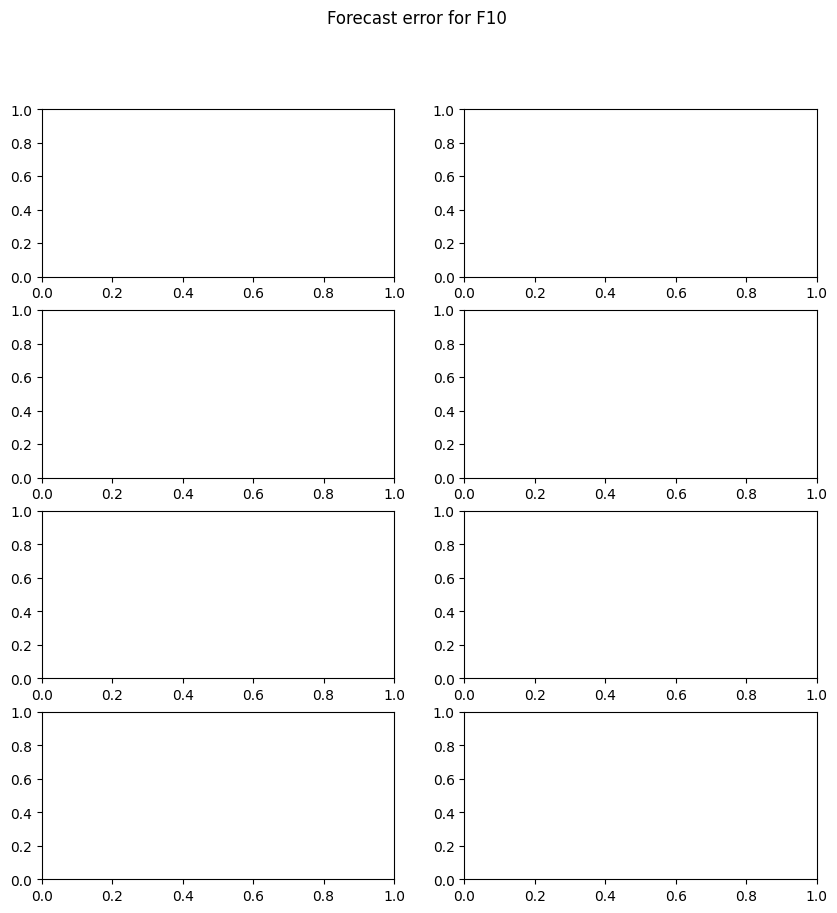

In [17]:
# hide
plot_solar_algorithm_performance(df_results, 'F10', ylims_mean=[(-5, 25), (-6, 30)],
                                 ylims_std=[(0, 30), (0, 42)])

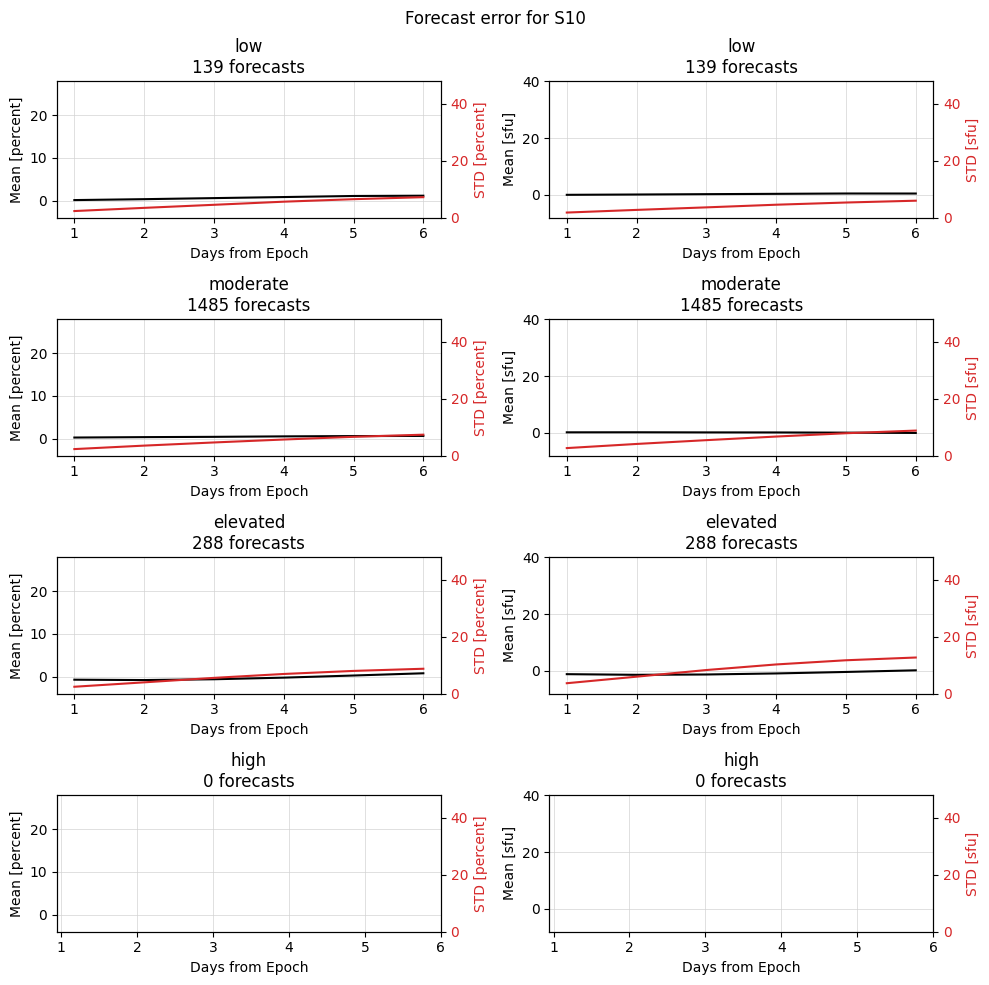

In [ ]:
# hide
plot_solar_algorithm_performance(df_results, 'S10', ylims_mean=[(-4, 28), (-8, 40)],
                                 ylims_std=[(0, 48), (0, 48)])

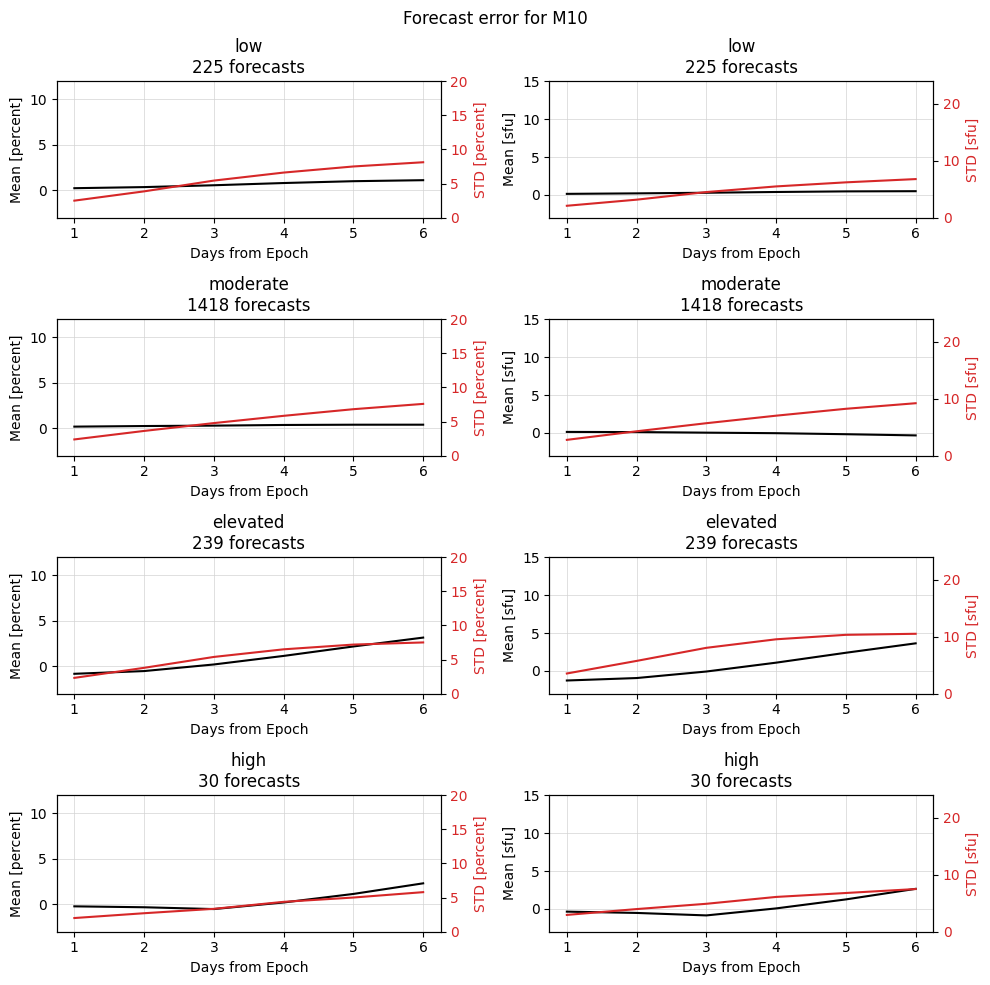

In [ ]:
# hide
plot_solar_algorithm_performance(df_results, 'M10', ylims_mean=[(-3, 12), (-3, 15)],
                                 ylims_std=[(0, 20), (0, 24)])

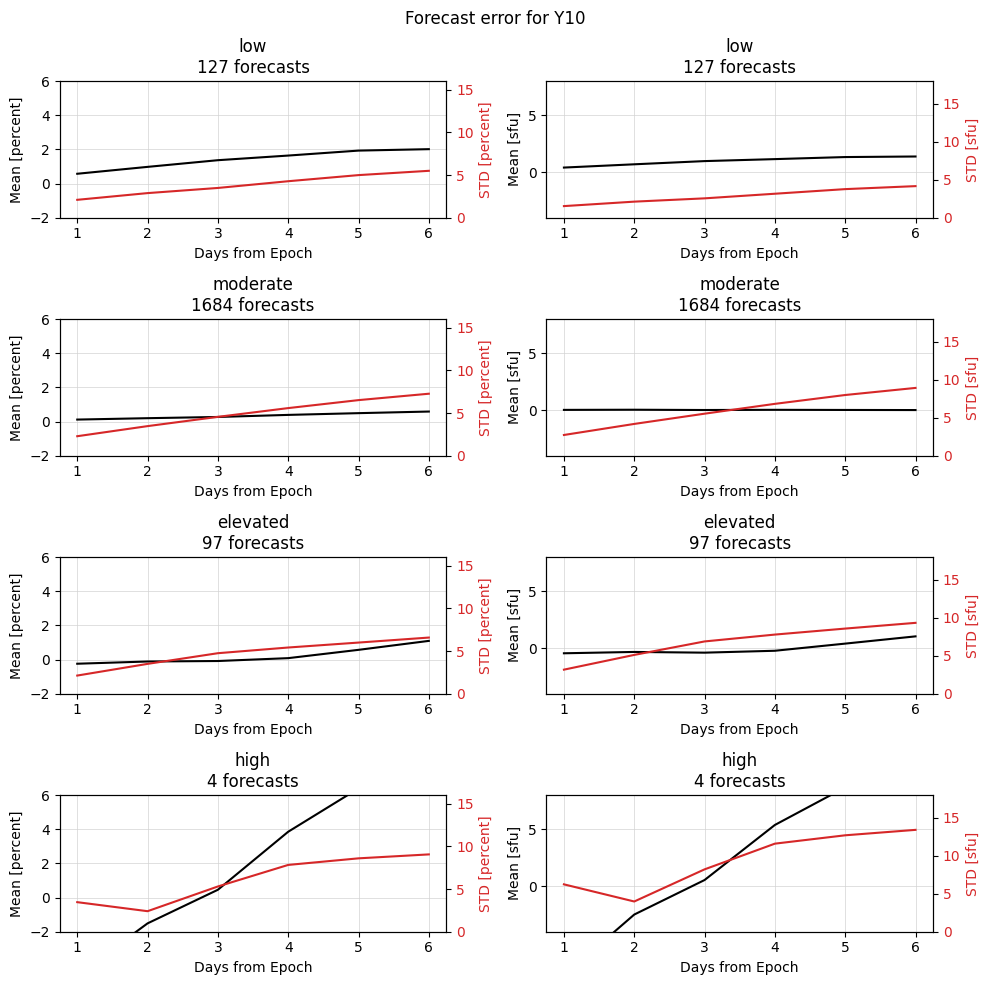

In [ ]:
# hide
plot_solar_algorithm_performance(df_results, 'Y10', ylims_mean=[(-2, 6), (-4, 8)],
                                 ylims_std=[(0, 16), (0, 18)])